
## <span style="color: blue;">Exploring Apache Spark for Movie Recommendation</span>

In this notebook, we delve into the world of Apache Spark and its role in crafting an effective movie recommendation system. Discover how the distributed computing prowess of Apache Spark, coupled with its MLlib library, empowers us to build personalized movie suggestions that cater to diverse user preferences.
<div style="margin-top: 20px;"></div>
<div style="text-align:center;">
    <img src="https://miro.medium.com/v2/resize:fit:1087/1*DC4f9ZEl0V0b-OJvEcBp4A.jpeg" alt="Image" width="600"/>
</div>



# Apache Spark Overview:

Apache Spark stands as a powerful, open-source distributed computing framework designed for processing vast amounts of data with remarkable speed and flexibility. Renowned for its in-memory processing capabilities, fault tolerance, and support for various data processing tasks, Spark's versatility extends to machine learning, streaming analytics, and interactive querying. Its distributed architecture makes it a prime candidate for developing intricate applications, such as our movie recommendation system, by enabling seamless data manipulation and processing across large clusters.
<div style="margin-top: 20px;"></div>
<div style="text-align:center;">
    <img src="https://d1.awsstatic.com/Data%20Lake/what-is-apache-spark.b3a3099296936df595d9a7d3610f1a77ff0749df.PNG" alt="Image" width="600"/>
</div>





# Import Required Libraries

In [1]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285413 sha256=d8470af2fa4581c795ddb8b5bfce1b26d70be49eea1f115d2ce50538fce13adf
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os
from pyspark.sql import SparkSession 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Preprocessing
**1. Create a Spark Session**

In [3]:
# Creating a Spark Session is an essential step when working with PySpark, and it serves as the entry point to using various Spark functionalities. 
#The SparkSession.builderallows you to configure various aspects of the session, such as the application name.

spark = SparkSession.builder.appName('Recommender_system').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/12 10:36:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# The data is read using the spark.read module, which is part of the PySpark SQL library. 
#This module provides methods to read data from various sources and convert it into a DataFrame
data = spark.read.csv("/kaggle/input/movie-recommendation-system/ratings.csv", header=True, inferSchema=True)
data.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
|     1|   1260|   3.5|1147877857|
|     1|   1653|   4.0|1147868097|
|     1|   2011|   2.5|1147868079|
|     1|   2012|   2.5|1147868068|
|     1|   2068|   2.5|1147869044|
|     1|   2161|   3.5|1147868609|
|     1|   2351|   4.5|1147877957|
|     1|   2573|   4.0|1147878923|
|     1|   2632|   5.0|1147878248|
|     1|   2692|   5.0|1147869100|
+------+-------+------+----------+
only showing top 20 rows



In [5]:
num_rows = data.count()

# Count the number of columns
num_columns = len(data.columns)

# Print the shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 25000095
Number of columns: 4


In [6]:
# Read data from CSV file
movie_names_data = spark.read.csv("/kaggle/input/movie-recommendation-system/movies.csv", header=True, inferSchema=True)
movie_names_data.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [7]:
# The printSchema()method in PySpark is used to display the schema of a DataFrame.
#The schema includes the data types of each column and provides valuable information about the structure of the data
data.printSchema()


root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [8]:
data.describe().show()

23/08/12 10:38:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+--------------------+
|summary|           userId|           movieId|            rating|           timestamp|
+-------+-----------------+------------------+------------------+--------------------+
|  count|         25000095|          25000095|          25000095|            25000095|
|   mean|81189.28115381162|21387.981943268616| 3.533854451353085|1.2156014431215513E9|
| stddev|46791.71589745776| 39198.86210105973|1.0607439611423535| 2.268758080595386E8|
|    min|                1|                 1|               0.5|           789652009|
|    max|           162541|            209171|               5.0|          1574327703|
+-------+-----------------+------------------+------------------+--------------------+



> To create a bar graph in PySpark using your data that includes ratings and film names,we'll first need to aggregate the data to compute some meaningful values for the bar graph. Since we want to visualize ratings for different films, we can calculate the average rating for each film. Then, we can use a visualization library like Matplotlib (integrated with PySpark) to create the bar graph.

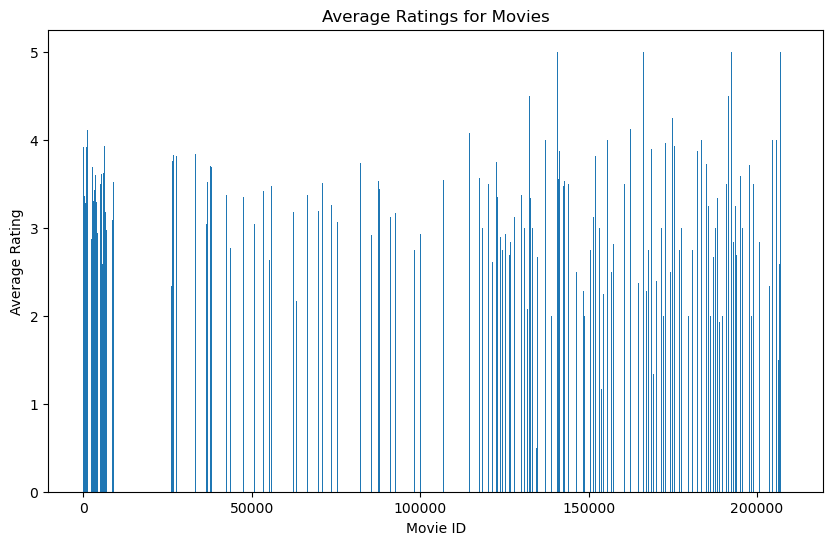

In [9]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg  

# Calculate average ratings for each movie
avg_ratings = data.groupBy("movieId").agg(avg("rating").alias("avg_rating"))

# Join the average ratings with movie names based on the movieId column
combined_data = avg_ratings.join(movie_names_data, on="movieId")

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
combined_data_pd = combined_data.toPandas()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(combined_data_pd["movieId"], combined_data_pd["avg_rating"])
plt.xlabel("Movie ID")
plt.ylabel("Average Rating")
plt.title("Average Ratings for Movies")
plt.show()


In [10]:

#the randomSplit()** method is used to split the DataFrame into training and testing sets. 
#The first argument [0.8, 0.2] specifies the relative sizes of the training and testing sets. 
#Here, 80% of the data is used for training, and 20% is used for testing. The seed parameter ensures reproducibility of the random split.
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

# Show the number of rows in the training and testing sets
print("Number of rows in train_data:", train_data.count())
print("Number of rows in test_data:", test_data.count())

Number of rows in train_data: 19997916


Number of rows in test_data: 5002179


# Collaborative Filtering and Content-Based Filtering :

are two common techniques used in recommendation systems, each with its own approach to generating recommendations. Let's explore the differences between these two approaches:

<div style="margin-top: 10px;"></div>
<div style="text-align:center;">
    <img src="https://media.licdn.com/dms/image/D5612AQEExRLStceeYA/article-cover_image-shrink_600_2000/0/1689434179800?e=2147483647&v=beta&t=KipDFqsnwxpf1QijFZ0zzpRPUgKDz4pcRRJONFzQwTc" alt="Image" width="600"/>
</div>




<div style="margin-top: 20px;"></div>

> **1. Collaborative Filtering:**

> Collaborative Filtering is a technique that makes recommendations based on the behavior and preferences of users. It assumes that users who agreed in the past (by liking, rating, or interacting with similar items) will agree in the future. Collaborative Filtering doesn't rely on explicit knowledge about items but rather on the patterns of user-item interactions.

There are two main types of Collaborative Filtering:

> **User-Based Collaborative Filtering:** This approach finds users who are similar to the target user based on their past interactions and recommends items liked by similar users.

> **Item-Based Collaborative Filtering**: This approach finds items that are similar to the target item based on users' past interactions and recommends similar items.

Collaborative Filtering can handle cases where user-item interactions are sparse or where there's no detailed information about the items. It often works well in scenarios where user preferences are dynamic and may change over time.

<div style="margin-top: 20px;"></div>
<div style="text-align:center;">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*3ALliiz9hG79_2xopzgyrQ.png" alt="Image" width="800"/>
</div>




<div style="margin-top: 30px;"></div>


> **2. Content-Based Filtering:**

> Content-Based Filtering, on the other hand, makes recommendations based on the characteristics (content) of items and a profile of the user's preferences. It involves extracting features or attributes from items and building user profiles based on the items they have liked or interacted with in the past.

The key steps in Content-Based Filtering are:

> **Feature Extraction:** Extract relevant features from the items (e.g., genre, keywords, actors, director, etc. for movies).

> **User Profile Creation:** Create a user profile based on the features of items the user has shown interest in.

> **Item-User Matching:** Recommend items that match the user profile based on content similarity.

Content-Based Filtering can provide personalized recommendations even when there's limited user-item interaction data. It's useful when you have detailed information about items and want to recommend items with specific features that match the user's preferences.

<div style="margin-top: 20px;"></div>
<div style="text-align:center;">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*H_MMnrpLQrqTSJHdDOCMoA.png" alt="Image" width=700"/>
</div>


In this notebook, we'll use the **ALS (Alternating Least Squares) algorithm** to build a recommendation model .

# ALS (Alternating Least Squares) Algorithm:

The Alternating Least Squares (ALS) algorithm is a matrix factorization technique commonly used in recommendation systems. It is particularly effective for collaborative filtering-based recommendations. ALS factors a large user-item interaction matrix into two lower-dimensional matrices, one representing users and the other representing items. This factorization allows the model to capture latent features that drive user preferences and item characteristics.

<div style="margin-top: 20px;"></div>
<div style="text-align:center;">
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRNTOCmkt_KnEczjqLaWkox57kelGe4TX05njwLCG1wjAX-Tf5C8qIdVDhNYPVr_Adf2kk&usqp=CAU" alt="Image" width="600"/>
</div>


<div style="margin-top: 20px;"></div>

Here's how ALS works:

**1. Matrix Factorization:** ALS begins with the user-item interaction matrix (often sparse), where rows represent users, columns represent items, and the entries contain user ratings or interactions.

**2. Initialization:** ALS initializes the user and item matrices with random or small values.

**3. Alternating Optimization:** The ALS algorithm iteratively alternates between optimizing the user factors (representing user preferences) while keeping the item factors fixed, and optimizing the item factors while keeping the user factors fixed. This alternating optimization process continues until it converges to a solution that minimizes the reconstruction error (least squares difference) between the original user-item interaction matrix and the product of the user and item factor matrices.

**4. Latent Features:** The key idea is that ALS learns latent features from the data. Each latent feature represents a hidden characteristic that contributes to user preferences or item characteristics. For example, in a movie recommendation system, latent features might capture genre preferences, actor popularity, or viewer demographics.

**5. Collaborative Filtering:** ALS leverages collaborative filtering, assuming that users who have agreed in the past (by rating or interacting with similar items) will agree in the future. By factorizing the user-item matrix, ALS can uncover these collaborative patterns.

**6. Implicit and Explicit Feedback:** ALS can handle both explicit feedback (e.g., explicit user ratings) and implicit feedback (e.g., user interactions such as clicks, views). It is particularly effective in scenarios with implicit feedback where explicit ratings are sparse.

**7. Parallelization:** ALS is designed for parallel and distributed computing, making it efficient for large-scale recommendation scenarios. It can be parallelized across users or items, leveraging the power of distributed systems.

**8. Model Evaluation:** After training, ALS can generate recommendations for items that users have not interacted with. These recommendations are based on the learned latent factors and can be evaluated using metrics like precision, recall, or root mean squared error (RMSE) for rating predictions.

# Modelling

In [11]:
from pyspark.ml.recommendation import ALS    

# Build the recommendation model using ALS on the training data
als = ALS(maxIter=15, regParam=0.01, userCol="userId" ,itemCol="movieId", ratingCol="rating")
#Fit the Model on Item-Based Data
model = als.fit(train_data)

In this step, the ALS model is initialized with the following parameters:
> 
> **maxIter:** The maximum number of iterations for the ALS optimization process.
> 
> **regParam:** The regularization parameter that helps control overfitting.
> 
> **userCol:** The name of the column representing user IDs in the DataFrame.
> 
> 
> **itemCol:** The name of the column representing item (movie) IDs in the DataFrame.
> 
> 
> **ratingCol:** The name of the column representing user ratings in the DataFrame.

# Evaluation

In [12]:
# Make predictions on the test data using the trained model
predictions = model.transform(test_data)

# Show the predictions, including original columns and the "prediction" column
predictions.show()


+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|     1|    307|   5.0|1147868828|  3.775222|
|     1|   1175|   3.5|1147868826|  4.285661|
|     1|   2011|   2.5|1147868079| 2.5890808|
|     1|   2012|   2.5|1147868068|  2.346777|
|     1|   2632|   5.0|1147878248| 3.6184216|
|     1|   3949|   5.0|1147868678| 4.0795074|
|     1|   4973|   4.5|1147869080| 4.4602065|
|     1|   5147|   4.0|1147877654| 3.7788172|
|     1|   5767|   5.0|1147878729|  3.702332|
|     1|   5878|   4.0|1147868807| 4.4601207|
|     1|   5912|   3.0|1147878698| 4.0899343|
|     1|   6370|   4.5|1147869191| 3.9104455|
|     1|   6539|   3.5|1147868461| 3.3873172|
|     1|   7327|   3.5|1147868855| 3.8776317|
|     1|   8014|   3.5|1147869155| 4.0531464|
|     1|   8729|   3.5|1147878452| 3.3115714|
| 32906|   1196|   5.0| 965798810|  4.502522|
| 32906|   1209|   5.0| 965799052|  4.632311|
| 32906|   1231|   5.0| 965802182|

In [13]:
# Drop rows where the "prediction" column has missing values (nulls)
predictions_no_missing = predictions.na.drop(subset=["prediction"])


> In this step, you're using the RegressionEvaluator to compute the **Root Mean Squared Error (RMSE)** between the predicted ratings ("predictionCol") and the actual ratings ("labelCol") in the test data. This metric provides a quantitative measure of how well the model's predictions align with the ground truth. 

<div style="margin-top: 20px;"></div>
<div style="text-align:center;">
    <img src="https://miro.medium.com/v2/resize:fit:966/1*lqDsPkfXPGen32Uem1PTNg.png" alt="Image" width="600"/>
</div>



In [14]:
from pyspark.ml.evaluation import RegressionEvaluator

# Create a RegressionEvaluator instance with the specified metricName and columns
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Compute the RMSE on the predictions using the RegressionEvaluator
rmse = evaluator.evaluate(predictions_no_missing)

# Print the calculated RMSE
print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 0.7990204104486563


> In this part, we're focusing on a single user with userId=12 from the test data. we select the ratings for this user, show their ratings, then use the trained model to make personalized recommendations for this user. The recommendations are displayed, ordered by the prediction score in descending order, which helps you understand which items (movies) are being recommended to the user based on their predicted preferences.

In [15]:
single_user = test_data.filter(test_data['userId']==12).select(['movieId','userId'])
# User had 10 ratings in the test data set 
# Realistically this should be some sort of hold out set!
single_user.show()

+-------+------+
|movieId|userId|
+-------+------+
|     21|    12|
|     32|    12|
|     36|    12|
|     48|    12|
|     54|    12|
|     97|    12|
|    141|    12|
|    150|    12|
|    231|    12|
|    261|    12|
|    317|    12|
|    329|    12|
|    344|    12|
|    433|    12|
|    435|    12|
|    505|    12|
|    516|    12|
|    531|    12|
|    546|    12|
|    555|    12|
+-------+------+
only showing top 20 rows



In [16]:
reccomendations = model.transform(single_user)
reccomendations.orderBy('prediction',ascending=False).show()

+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
|   1221|    12|  4.463186|
|   4973|    12| 4.4138527|
|    745|    12|  4.412603|
|    750|    12|  4.408183|
|   1212|    12| 4.2824597|
|   3435|    12| 4.2821407|
|    910|    12| 4.2551937|
|   1288|    12| 4.2434106|
|  55820|    12|  4.227254|
|   8961|    12| 4.2199903|
|   1267|    12| 4.1800976|
|   2804|    12|  4.154967|
|   1089|    12| 4.1333623|
|  48394|    12|  4.125283|
|   6377|    12|  4.112085|
|   4027|    12| 4.0882163|
|   1244|    12|  4.074768|
|  30749|    12| 4.0727825|
|   1449|    12|  4.068479|
|   5669|    12|  4.055026|
+-------+------+----------+
only showing top 20 rows

